In [ ]:
#Algo utilisé SVM(Sector Vector Machine) le but de classer le dataset en 2 ou plusieurs classes en trouvant la meilleure frontiere de séparation possible

In [7]:
#On va commencer par charger le fichier depuis google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/tmp/ipython-input-3-2435192127.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


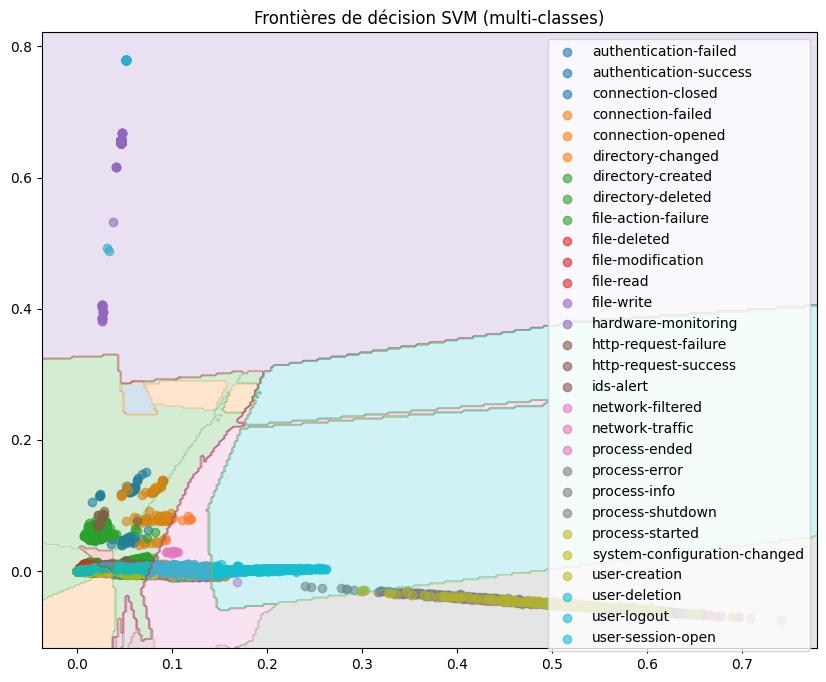

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import csv

# Préparer nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # enlever ce qui n'est pas lettre
    text = re.sub(r'[^a-z\s]', '', text)
    # tokenisation + stopwords + lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Charger les données (supposé déjà fait par toi)
file_path = '/content/drive/MyDrive/SVM/output_0.1.log'
df = pd.read_csv(file_path, sep=',', header=0, on_bad_lines='skip')
df = df.dropna(subset=['category', 'log'])

# Appliquer preprocessing sur les logs
df['clean_log'] = df['log'].apply(preprocess_text)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(df['clean_log'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])



# 1. Extraire TF-IDF sans pipeline
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# 2. Réduire à 2 dimensions
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_train_2d = svd_2d.fit_transform(X_train_tfidf)

# 3. Entraîner un SVM linéaire sur ces données 2D
svm_2d = SVC(kernel='linear', C=1)
svm_2d.fit(X_train_2d, y_train)

# 4. Tracer les points et la frontière de décision
def plot_svm_decision_multiclass(X, y, model):
    plt.figure(figsize=(10, 8))
    unique_classes = np.unique(y)
    colors = plt.cm.get_cmap('tab10', len(unique_classes))

    for idx, classe in enumerate(unique_classes):
        plt.scatter(X[y == classe, 0], X[y == classe, 1], label=classe, alpha=0.6, color=colors(idx))

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Grille
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 300),
                         np.linspace(ylim[0], ylim[1], 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Prédictions sur grille (labels sous forme texte)
    Z = model.predict(grid)

    # Convertir les labels en entiers
    class_to_int = {c: i for i, c in enumerate(unique_classes)}
    Z_num = np.array([class_to_int[label] for label in Z])

    Z_num = Z_num.reshape(xx.shape)

    # Colorer les régions selon la classe prédite
    plt.contourf(xx, yy, Z_num, alpha=0.2, levels=np.arange(len(unique_classes) + 1) - 0.5, cmap='tab10')

    plt.legend()
    plt.title("Frontières de décision SVM (multi-classes)")
    plt.show()


plot_svm_decision_multiclass(X_train_2d, y_train.values, svm_2d)



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('svm', SVC(kernel='linear', C=1))
])

pipe.fit(X_train, y_train)


# Prédictions sur les données d'entrainement
y_train_pred = pipe.predict(X_train)

print("=== Performance sur TRAIN ===")
print("Accuracy train:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, zero_division=0))

# Prédictions sur les données de test
y_test_pred = pipe.predict(X_test)

print("=== Performance sur TEST ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, zero_division=0))


=== Performance sur TRAIN ===
Accuracy train: 0.978371724986812
                              precision    recall  f1-score   support

       authentication-failed       1.00      0.94      0.97       770
      authentication-success       0.94      0.92      0.93       781
           connection-closed       0.99      1.00      0.99       685
           connection-failed       0.93      1.00      0.96       790
           connection-opened       0.99      0.95      0.97       817
           directory-changed       1.00      0.84      0.91       934
           directory-created       1.00      1.00      1.00       933
           directory-deleted       0.85      0.99      0.91       934
         file-action-failure       1.00      1.00      1.00       934
                file-deleted       1.00      0.82      0.90       933
           file-modification       0.87      1.00      0.93       934
                   file-read       1.00      1.00      1.00       934
                  file-wr

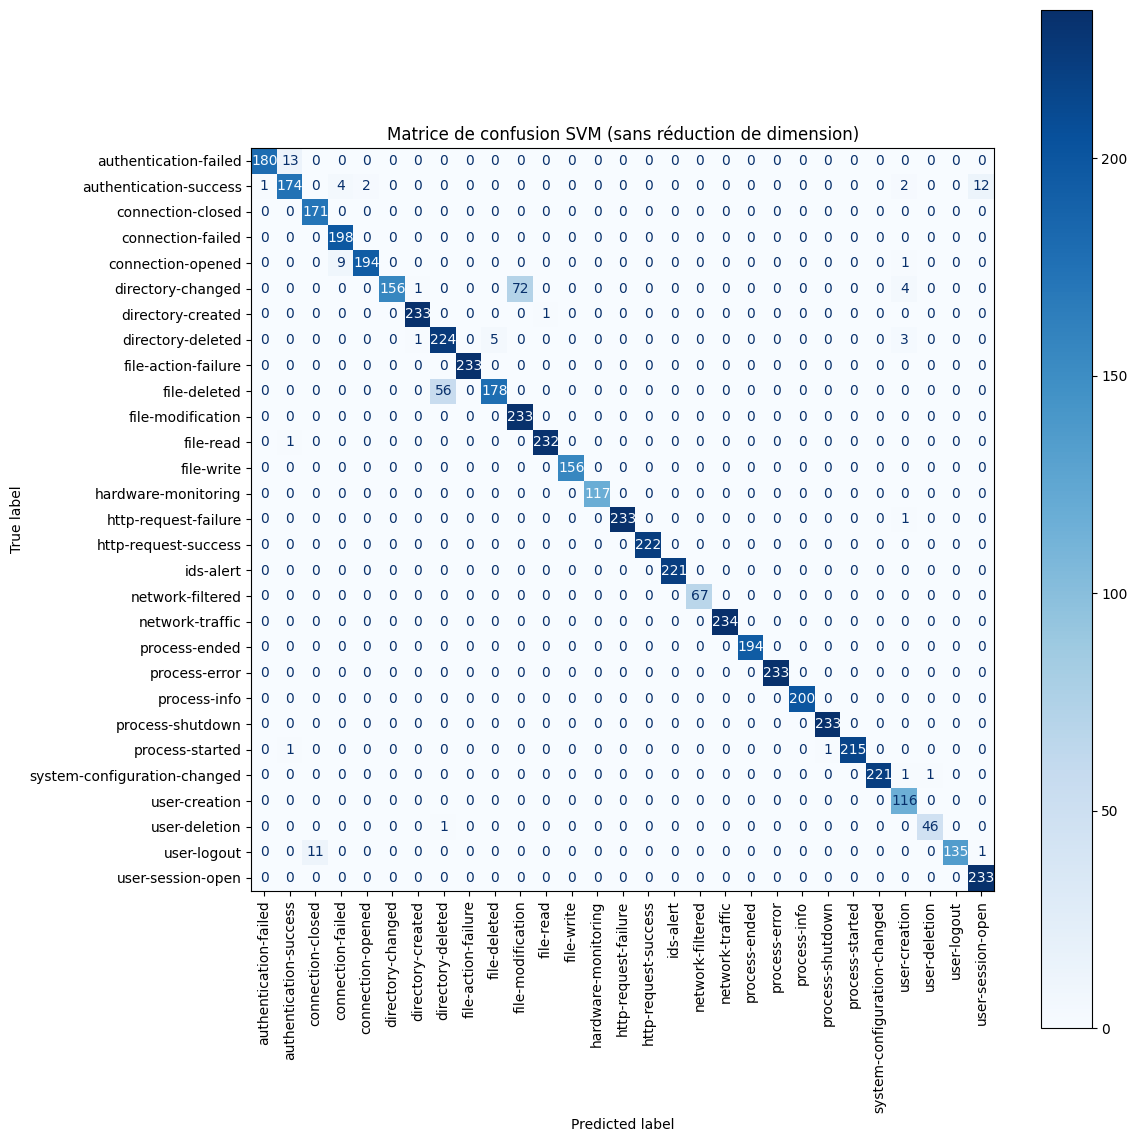

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pipeline complet SANS réduction de dimension
pipeline_no_svd = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1))
])
# Entraînement
pipeline_no_svd.fit(X_train, y_train)

# Prédiction
y_pred_no_svd = pipeline_no_svd.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_no_svd, labels=pipeline_no_svd.classes_)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_no_svd.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Matrice de confusion SVM (sans réduction de dimension)")
plt.tight_layout()
plt.show()


In [ ]:
#Overfitting
# 1. Surapprentissage : SVM RBF, C très grand, gamma élevé
pipeline_overfit = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='rbf', C=1e10, gamma=1000))
])

pipeline_overfit.fit(X_train, y_train)
y_pred_overfit_train = pipeline_overfit.predict(X_train)
y_pred_overfit_test = pipeline_overfit.predict(X_test)

print("=== Surapprentissage ===")
print("Train accuracy:", accuracy_score(y_train, y_pred_overfit_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_overfit_test))
print(classification_report(y_test, y_pred_overfit_test))

=== Surapprentissage ===
Train accuracy: 1.0
Test accuracy: 0.11919831223628692
                              precision    recall  f1-score   support

       authentication-failed       1.00      0.05      0.10       193
      authentication-success       0.00      0.00      0.00       195
           connection-closed       1.00      0.03      0.06       171
           connection-failed       1.00      0.07      0.13       198
           connection-opened       1.00      0.16      0.28       204
           directory-changed       1.00      0.12      0.21       233
           directory-created       0.00      0.00      0.00       234
           directory-deleted       1.00      0.14      0.25       233
         file-action-failure       1.00      0.55      0.71       233
                file-deleted       0.00      0.00      0.00       234
           file-modification       0.91      0.47      0.62       233
                   file-read       0.04      1.00      0.08       233
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Correction méthode 1
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Pipeline avec SVM RBF mais réglage modéré de C et gamma
pipeline_corrected = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

pipeline_corrected.fit(X_train, y_train)

y_pred_train = pipeline_corrected.predict(X_train)
y_pred_test = pipeline_corrected.predict(X_test)

print("=== Modèle optimisé ===")
print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


=== Modèle optimisé ===
Train accuracy: 0.9738878143133463
Test accuracy: 0.9614978902953587
                              precision    recall  f1-score   support

       authentication-failed       0.98      0.94      0.96       193
      authentication-success       0.91      0.90      0.90       195
           connection-closed       0.94      1.00      0.97       171
           connection-failed       0.96      0.95      0.96       198
           connection-opened       0.94      0.97      0.95       204
           directory-changed       1.00      0.67      0.81       233
           directory-created       0.99      0.99      0.99       234
           directory-deleted       0.80      0.97      0.88       233
         file-action-failure       1.00      1.00      1.00       233
                file-deleted       0.98      0.76      0.86       234
           file-modification       0.77      1.00      0.87       233
                   file-read       0.99      0.99      0.99       

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Réduction des données à 10% pour provoquer l'overfit
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train)

noisy_tokens = ["junkdata", "xyz", "panic", "fatal", "segfault", "crash", "weirdtoken", "null", "oops", "strange"]

X_train_noisy = [x + " " + " ".join(np.random.choice(noisy_tokens, 15)) for x in X_small]
X_test_noisy = X_test

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='poly', degree=5, C=1e5))
])

pipeline.fit(X_train_noisy, y_small)

print("Train acc:", accuracy_score(y_small, pipeline.predict(X_train_noisy)))
print("Test acc:", accuracy_score(y_test, pipeline.predict(X_test_noisy)))
print(classification_report(y_test, pipeline.predict(X_test_noisy)))


Train acc: 1.0
Test acc: 0.7100914205344585
                              precision    recall  f1-score   support

       authentication-failed       0.94      0.37      0.53       193
      authentication-success       0.97      0.45      0.62       195
           connection-closed       1.00      0.72      0.84       171
           connection-failed       1.00      0.79      0.88       198
           connection-opened       0.90      0.59      0.72       204
           directory-changed       0.89      0.47      0.61       233
           directory-created       0.14      1.00      0.24       234
           directory-deleted       0.75      0.68      0.71       233
         file-action-failure       1.00      0.93      0.96       233
                file-deleted       0.99      0.75      0.86       234
           file-modification       0.78      0.93      0.85       233
                   file-read       1.00      0.87      0.93       233
                  file-write       1.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Correction Methode 2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Revenir à un jeu de données plus grand (ex : 70%)
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=0.7, stratify=y_train)

# Éviter d'ajouter du bruit inutile
X_train_cleaned = X_small
X_test_cleaned = X_test

# Pipeline corrigé avec SVM plus simple
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))  # Choix raisonnable
])

pipeline.fit(X_train_cleaned, y_small)

print("=== Modèle corrigé ===")
print("Train accuracy:", accuracy_score(y_small, pipeline.predict(X_train_cleaned)))
print("Test accuracy:", accuracy_score(y_test, pipeline.predict(X_test_cleaned)))
print(classification_report(y_test, pipeline.predict(X_test_cleaned)))


=== Modèle corrigé ===
Train accuracy: 0.9733718520379325
Test accuracy: 0.9625527426160337
                              precision    recall  f1-score   support

       authentication-failed       0.97      0.94      0.95       193
      authentication-success       0.93      0.89      0.91       195
           connection-closed       0.94      1.00      0.97       171
           connection-failed       0.93      0.99      0.96       198
           connection-opened       0.98      0.94      0.96       204
           directory-changed       0.99      0.67      0.80       233
           directory-created       0.99      0.99      0.99       234
           directory-deleted       0.80      0.98      0.88       233
         file-action-failure       1.00      1.00      1.00       233
                file-deleted       0.99      0.76      0.86       234
           file-modification       0.77      1.00      0.87       233
                   file-read       0.99      0.99      0.99       2

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# Suppose que X_train, y_train, X_test, y_test existent déjà

# Étape 1 : Prétraitement (optionnel)
# TODO: Ajouter nettoyage si besoin
X_train_cleaned = X_train
y_train_cleaned = y_train
X_test_cleaned = X_test

# Étape 2 : Pipeline SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Étape 3 : Entraînement
pipeline.fit(X_train_cleaned, y_train_cleaned)

# Étape 4 : Évaluation
y_pred = pipeline.predict(X_test_cleaned)
print("=== Modèle entraîné ===")
print("Train accuracy:", accuracy_score(y_train_cleaned, pipeline.predict(X_train_cleaned)))
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Étape 5 : Sauvegarde
model_path = "/content/drive/MyDrive/SVM/svm_pipeline_model.pkl"
joblib.dump(pipeline, model_path)
print("✅ Modèle sauvegardé sous 'svm_pipeline_model.pkl'")

# Étape 6 : Rechargement et vérification
model_loaded = joblib.load(model_path)
y_pred_loaded = model_loaded.predict(X_test_cleaned)
print("=== Modèle rechargé ===")
print("Test accuracy (modèle chargé):", accuracy_score(y_test, y_pred_loaded))
print(classification_report(y_test, y_pred_loaded))


=== Modèle entraîné ===
Train accuracy: 0.9738878143133463
Test accuracy: 0.9614978902953587
                              precision    recall  f1-score   support

       authentication-failed       0.98      0.94      0.96       193
      authentication-success       0.91      0.90      0.90       195
           connection-closed       0.94      1.00      0.97       171
           connection-failed       0.96      0.95      0.96       198
           connection-opened       0.94      0.97      0.95       204
           directory-changed       1.00      0.67      0.81       233
           directory-created       0.99      0.99      0.99       234
           directory-deleted       0.80      0.97      0.88       233
         file-action-failure       1.00      1.00      1.00       233
                file-deleted       0.98      0.76      0.86       234
           file-modification       0.77      1.00      0.87       233
                   file-read       0.99      0.99      0.99       